# Homework 2: Function approximation

**Your task**

- Implement experience replay for CartPole with linear function approximation.  (4p)

- **Bonus**: implement DQN with experience replay. Use a neural network instead of a linear approximator (2p):

- *Bonus points*: 1 bug found in my code (hopefully none, but it happens) = 1 extra point.
    - Bug 1: td_target calculation should use `np.max(estimator.predict(new_state))` instead of `np.amax()`
    - Bug 2: set `state = new_state` at the end of `while not done:` loop

You can borrow inspiration from tutorial 5 (`05 fa_cartpole_sklearn.py`).

#### My comments

The training is still quite unstable and sensitive to the behavior at the beginning.

In [74]:
%matplotlib inline
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
from sklearn.linear_model import SGDRegressor

In [87]:
def plot_rewards(avg_rewards, title):
    plt.plot(np.array(range(len(avg_rewards)))*100, avg_rewards)
    plt.ylabel('average reward in 100 episodes')
    #plt.ylim(0.2, 1)
    plt.xlabel('episode')
    plt.title(title)

class FunctionEstimator:
    def __init__(self,env, alpha=0.001):
        self.alpha = alpha
        self.env = env
        self.n_actions = env.action_space.n
        self.possible_actions = range(env.action_space.n)
        self.initial_state = self.featurize(env.reset())
        self.state_dim = len(self.initial_state)
        self.w = np.ones(shape=(self.state_dim, self.n_actions), dtype=float) #parameters of the function approximating Q table
    
    def featurize(self,state):
        """
        Turn state into feature vector so it can be inputted into the function approximating Q table.
        """
        return np.tanh(state)
    
    def gradient(self, state, action):
        """
        f(state,action) = state*w_action
        df(state, action)/dw_action = state
        """
        return state
    
    def update(self, state, action, td_target):
        """
        Update the parameters by gradient descend.
        Move the result of f(state, action) closer to target = minimize squared error.
        """
        state = self.featurize(state) 
        
        target = td_target
        prediction = self.predict(state)[action]
        error = target - prediction
        gradient = self.gradient(state, action)
        
        self.w[:,action] -= self.alpha * error * (-1 * gradient)
        
    def batch_update(self, history, batch_size=5):
        history = np.array(history)
        length = history.shape[0]
        
        if length <= batch_size:
            batch = history
        else:
            idxs = np.random.choice(length, batch_size, replace=False) #select indexes of points from history
            batch = history[idxs] # select points from history to learn from
        
        for i in range(batch.shape[0]):
            [state, action, reward, new_state, td_target] = batch[i]
            self.update(state, action, td_target)
        
    def predict(self,state):
        """
        Predict Q-values of every action in a given state.
        Policy will then select which action to take based on these Q-values.
        """
        state = self.featurize(state)
        return np.dot(state, self.w).flatten() # linear function

        
def make_policy(estimator, epsilon):
    """
    Epsilon greedy policy choosing which action to take.
    """
    def policy_fn(state):
        preds = estimator.predict(state)
        if np.random.rand()>epsilon:
            action = np.argmax(preds)
        else:
            action = np.random.choice(estimator.possible_actions)
        return action
    
    return policy_fn


def run_episodes(n_episodes = 1000, gamma = 1, experience_replay=False):
    env = gym.make('CartPole-v0')

    estimator = FunctionEstimator(env)
    history = []
    episode_rewards = []
    avg_episode_rewards = []

    for ep in range(n_episodes):
        state = env.reset()
        done = False
        policy = make_policy(estimator, 0.99**ep) # reduce epsilon
        ep_reward = 0

        while not done:
            action = policy(state)
            new_state, reward, done, _ = env.step(action)
            ep_reward += reward

            # Calculate the target Q-value we want to approximate
            if done:
                td_target = ep_reward
            else:
                td_target = reward + gamma*np.max(estimator.predict(new_state))
            
            # Keep track of the states    
            history.append([state, action, reward, new_state, td_target])
            
            # Update the parameters of our approximator
            if experience_replay:
                estimator.batch_update(history[-500:])   # with experience replay, select only from last 100 episodes for performance reasons
            else:
                estimator.update(state,action,td_target) # without experience replay
            
            state = new_state

        episode_rewards.append(ep_reward)
        # Show stats
        if (ep) % 100 == 0:
            avg_episode_rewards.append(np.average(episode_rewards[-100:]))
            print("Reward at episode {} is {} | avg in last 100: {}"
                  .format(ep,ep_reward, avg_episode_rewards[-1]))
            
    env.close()
    return episode_rewards, avg_episode_rewards

In [69]:
episode_rewards_no_exp, avg_episode_rewards_no_exp = run_episodes(n_episodes=1000, experience_replay=False)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Reward at episode 0 is 12.0 | avg in last 100: 12.0
Reward at episode 100 is 177.0 | avg in last 100: 56.52
Reward at episode 200 is 200.0 | avg in last 100: 165.3
Reward at episode 300 is 174.0 | avg in last 100: 196.28
Reward at episode 400 is 200.0 | avg in last 100: 195.89
Reward at episode 500 is 200.0 | avg in last 100: 187.29
Reward at episode 600 is 200.0 | avg in last 100: 193.88
Reward at episode 700 is 200.0 | avg in last 100: 188.91
Reward at episode 800 is 125.0 | avg in last 100: 180.29
Reward at episode 900 is 148.0 | avg in last 100: 175.12


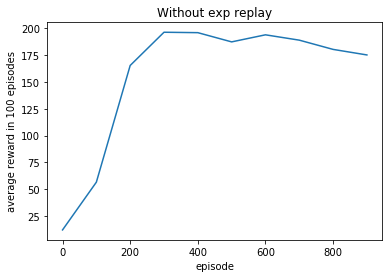

In [75]:
plot_rewards(avg_episode_rewards_no_exp, "Without experience replay")

In [92]:
episode_rewards_exp, avg_episode_rewards_exp = run_episodes(n_episodes=1000, experience_replay=True)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Reward at episode 0 is 14.0 | avg in last 100: 14.0
Reward at episode 100 is 160.0 | avg in last 100: 67.65
Reward at episode 200 is 116.0 | avg in last 100: 176.43
Reward at episode 300 is 200.0 | avg in last 100: 185.31
Reward at episode 400 is 200.0 | avg in last 100: 192.09
Reward at episode 500 is 75.0 | avg in last 100: 168.84
Reward at episode 600 is 200.0 | avg in last 100: 197.24
Reward at episode 700 is 165.0 | avg in last 100: 184.23
Reward at episode 800 is 200.0 | avg in last 100: 175.79
Reward at episode 900 is 200.0 | avg in last 100: 200.0


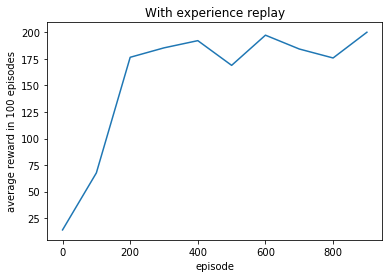

In [93]:
plot_rewards(avg_episode_rewards_exp, "With experience replay")